# Combining models

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uns
from uns import training

In [3]:
models = ('703','803','903','802','801','902')
# assume that all of the model have the same set
indices = np.where(training['model_'+models[0]] == 'validate')[0]
outputfiles = {model:uns.uns_files('validate','predictions',model) for model in models}

In [48]:
def plot_prob_file(ax, filename, mask=False):
    p = np.load(filename)
    if mask:
        ax[1].imshow(p[1,:,:], vmin=0, vmax=1, cmap=plt.cm.gray)
    else:
        ax = [ax]
    ax[0].imshow(p[0,:,:], vmin=0, vmax=1, cmap=plt.cm.inferno)
    for a in ax:
        a.axis('equal')
        a.axis('off')
        a.tick_params(which='both', axis='both',
                       bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        a.autoscale(tight=True)

def plot_prob(pr, gt=None, ax=None):  
    if ax is None:
        if gt is None:
            fig, ax = subplots()
        else:
            fig, ax = subplots(1,2)
    if gt is None:
        ax = [ax]
    
    ax[0].imshow(pr, vmin=0, vmax=1, cmap=plt.cm.inferno)
    if gt is not None:
        ax[1].imshow(gt, cmap=plt.cm.gray)
    for a in ax:
        a.axis('equal')
        a.axis('off')
        a.tick_params(which='both', axis='both',
                       bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        a.autoscale(tight=True)
    return ax  
    
def dice(preds, truth):
    numer = 2*np.sum(np.logical_and(preds, truth), axis=(1,2))
    denom = np.sum(preds, axis=(1,2)) + np.sum(truth, axis=(1,2))
    scores = np.empty(preds.shape[0])
    scores[denom<1] = 1  # denom==0 implies numer==0
    idx = denom>0
    scores[idx] = numer[idx]/denom[idx]
    return scores

def evaluate_cutoffs(preds, masks, maskfun=lambda x:x, 
                     cutoffs=np.linspace(0.1,1.0,num=10),
                     minimumsizes = np.arange(0,4000,200)):
    filtscores = np.zeros((len(cutoffs), len(minimumsizes)))
    blank_masks = np.zeros_like(masks)
    blank_scores = dice(blank_masks, masks)
    for i,c in enumerate(cutoffs):
        predmasks = maskfun(preds>c)
        rawscore = dice(predmasks, masks)
        predpix = np.sum(predmasks, axis=(1,2))
        for j,m in enumerate(minimumsizes):
            predictblank = predpix<m
            minscores = np.where(predictblank, blank_scores, rawscore)
            filtscores[i,j] = np.mean(minscores)
    return cutoffs, minimumsizes, filtscores

def model_average(models, indices, weights=np.ones(100)):
    Pavg = []
    gt_masks = []
    for j,jdx in enumerate(indices):
        P = []
        for m,w in zip(models, weights):
            record = np.load(outputfiles[m][j])
            P.append(record[0]*w)

        Pavg.append(np.mean(P, axis=0))
        gt_masks.append(record[1])
    return np.array(Pavg), np.array(gt_masks)

def load_model(model, indices):
    Pr = []
    GT = []
    for idx in indices:
        record = np.load(outputfiles[model][jdx])
        Pr.append(record[0])
        GT.append(record[1])
    return np.array(Pr), np.array(GT)
  

def plot_model_dice(Pavg, gt_masks, ax=None, title=None, **kwargs):
    cutoffs, minimumsizes, filtscores = evaluate_cutoffs(Pavg, gt_masks, **kwargs)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    lh = ax.plot(minimumsizes, filtscores.T)
    ax.legend(['{:.1f}'.format(c) for c in cutoffs])
    ax.set_xlabel('Minimum mask size')
    ax.set_ylabel('Score')
    if title is not None:
        ax.set_title(title)
    return lh

## Plot model probabilities and ground truth

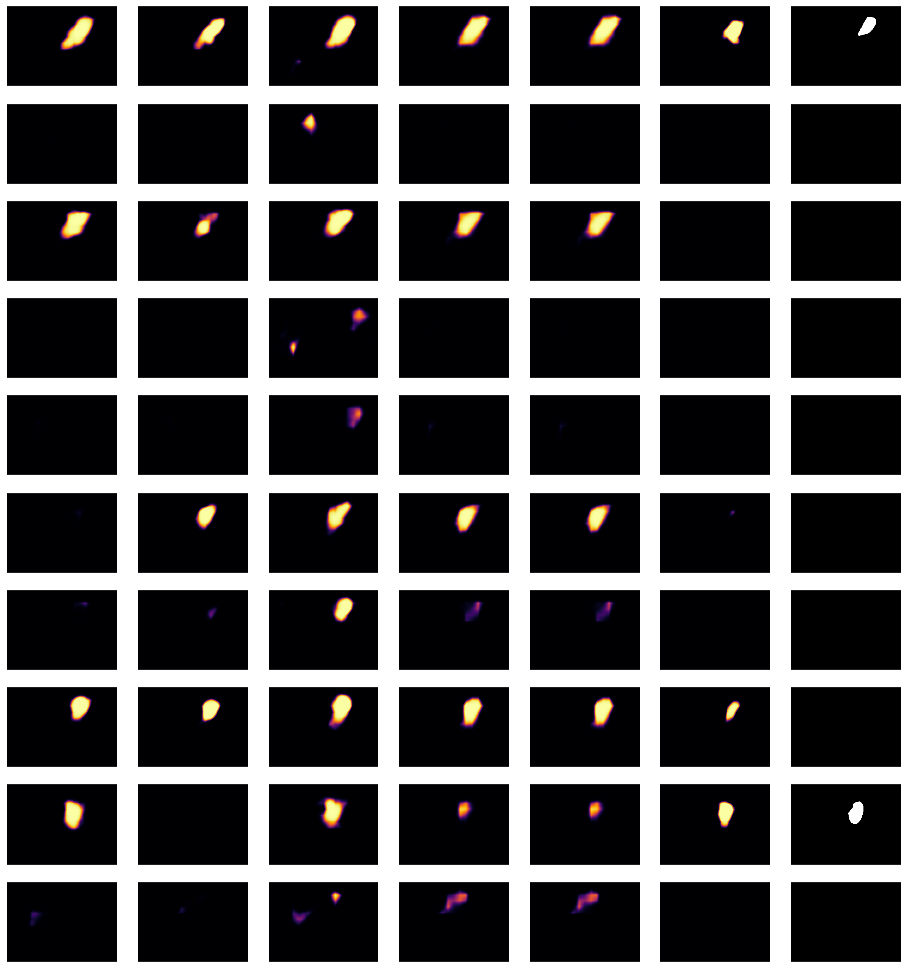

In [51]:
N = 10
fig, ax = plt.subplots(N,len(models)+1, figsize=(16,16/(len(models)+1)*3/4*N))
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N)
for j,jdx in enumerate(subset):
    for i,m in enumerate(models):
        if i==0:
            plot_prob_file([ax[j,i], ax[j,-1]], outputfiles[m][jdx], mask=True)
        else:
            plot_prob_file(ax[j,i], outputfiles[m][jdx])
      

In [52]:
pltsubset = subset

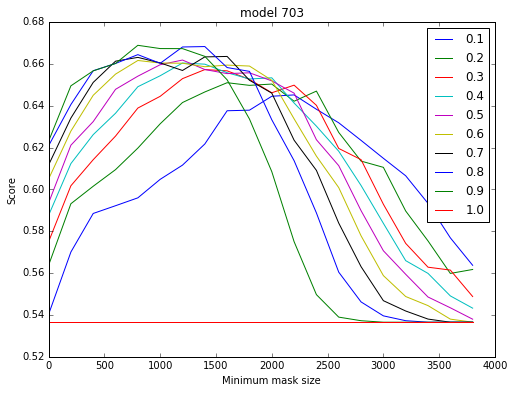

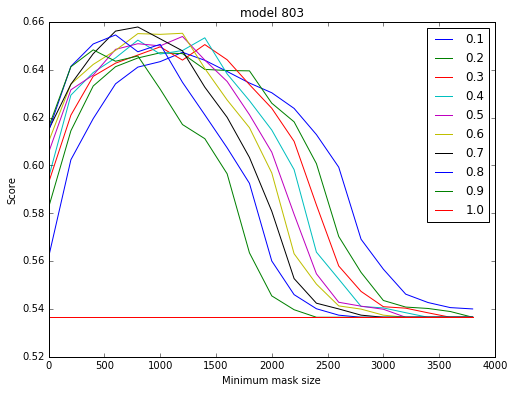

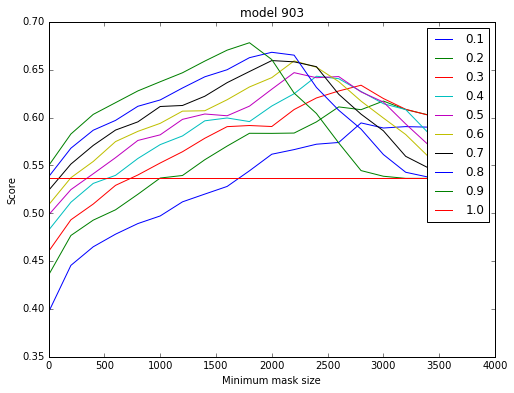

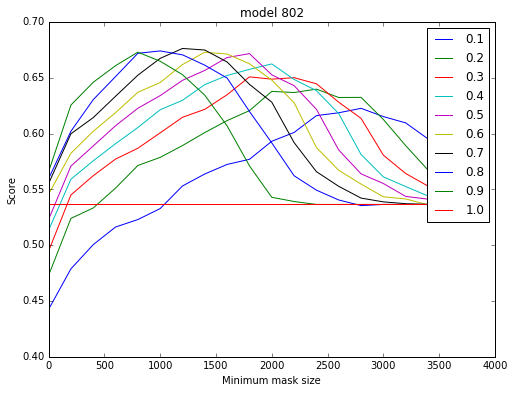

In [11]:
for model in models[:4]:
    pr, gt = load_model(model, indices)
    plot_model_dice(pr, gt, title='model ' + model)
    plt.show()

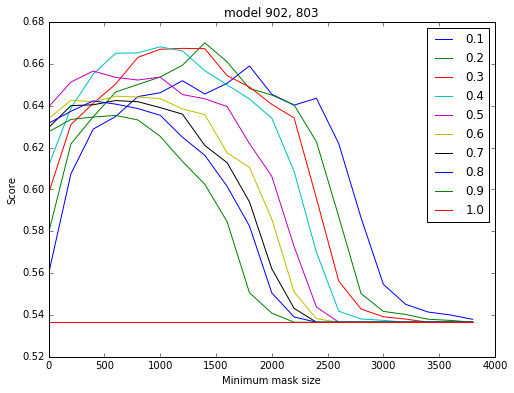

In [14]:
combo = ['902','803']
Pavg, gt_masks = model_average(combo, indices)
plot_model_dice(Pavg, gt_masks, title='model ' + ', '.join(combo))
plt.show()

## Combine models with different weights then produce the output

In [56]:
# use a random subset to start:
N = 200
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N)

#load the files into memory
Pr = {}
for model in models:
    Pr[model], GT = load_model(model, subset)


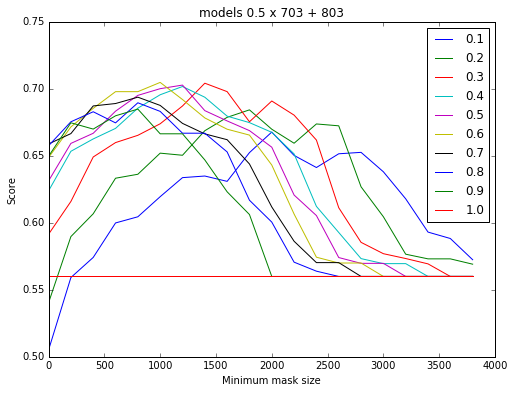

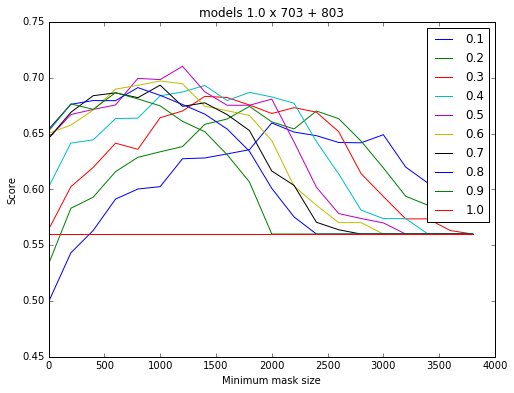

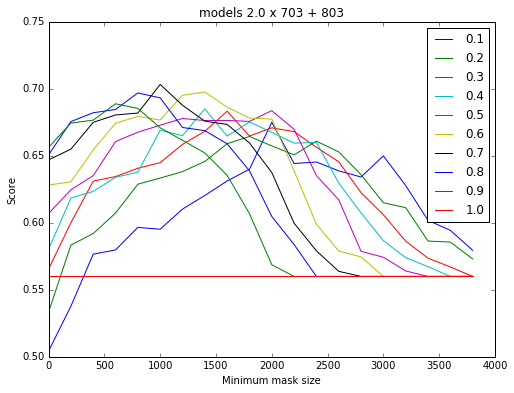

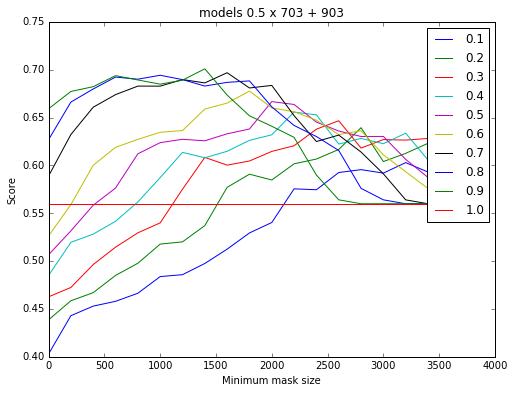

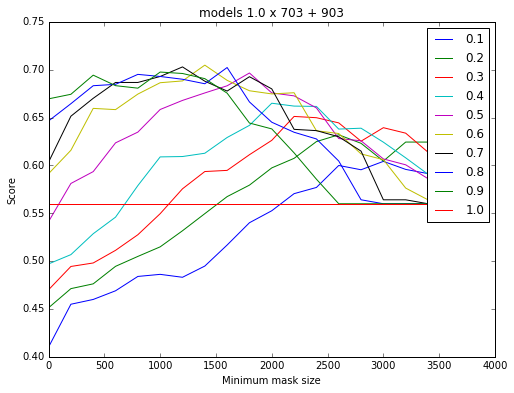

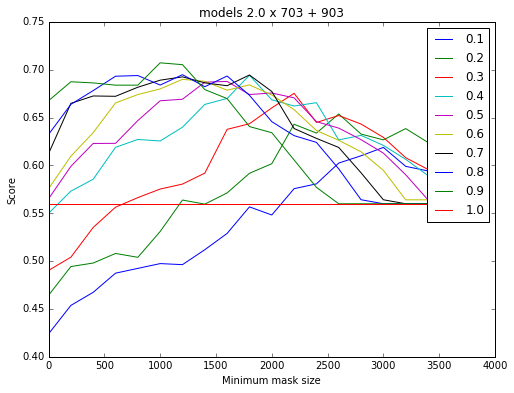

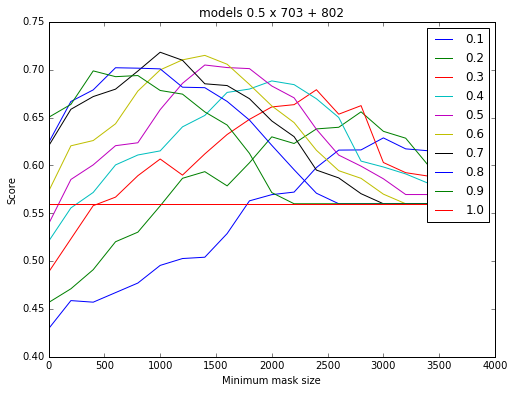

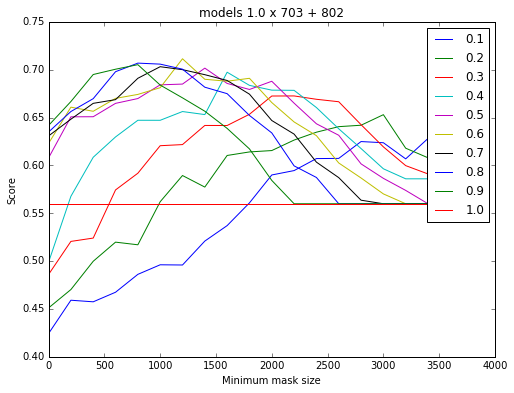

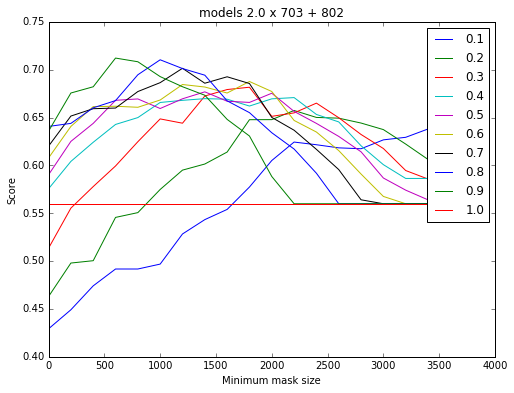

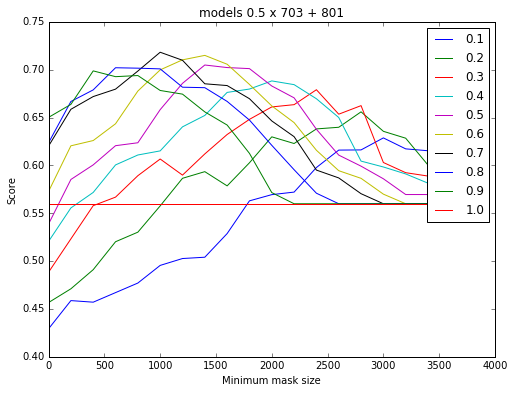

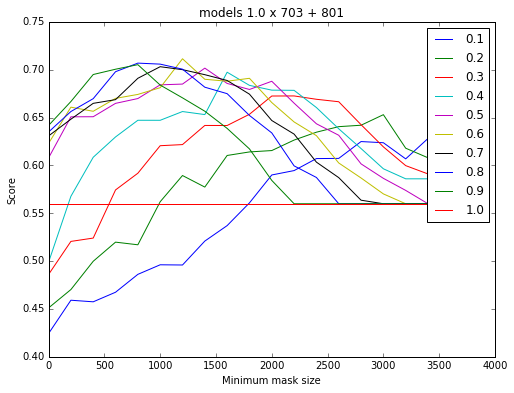

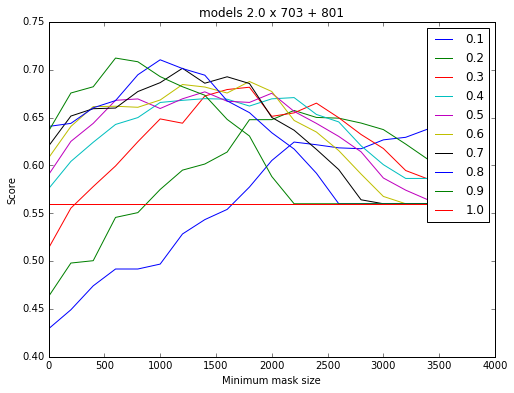

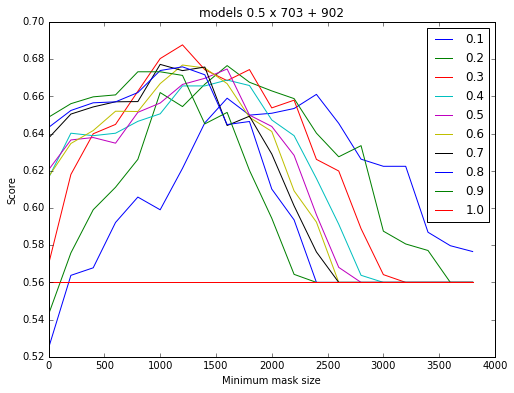

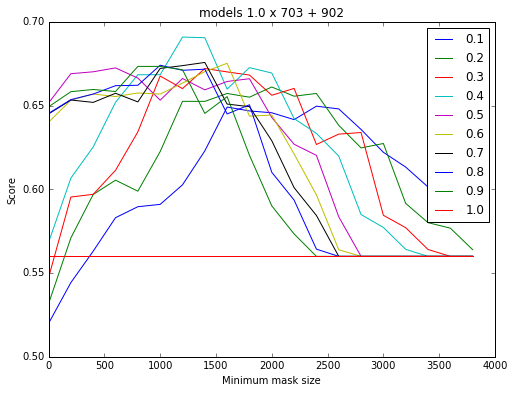

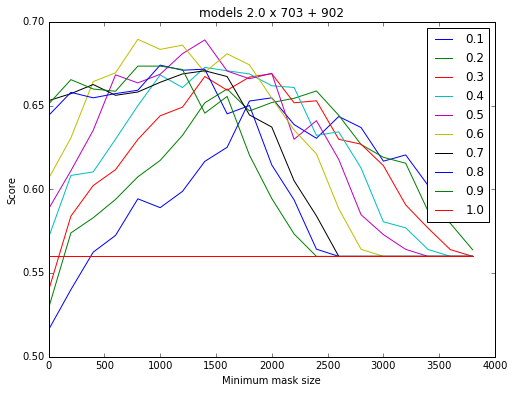

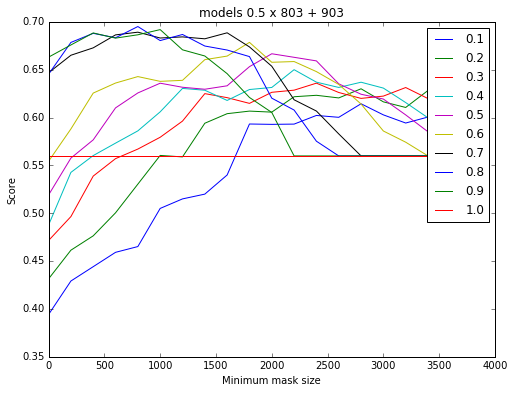

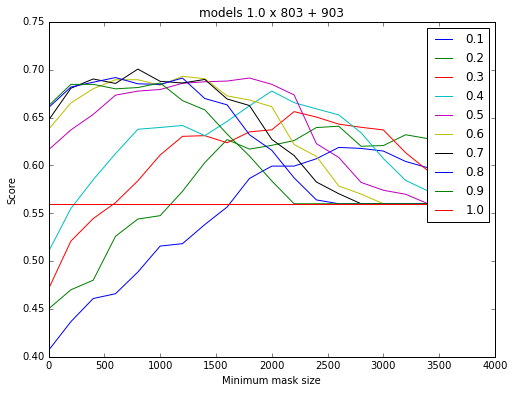

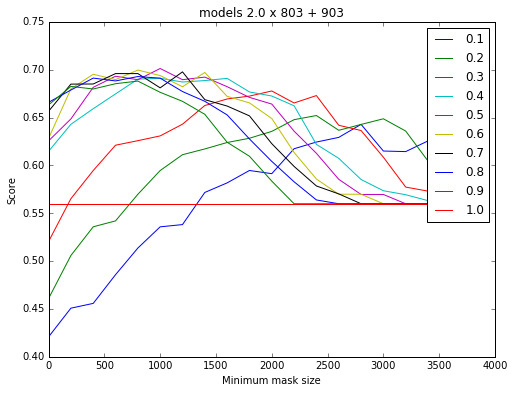

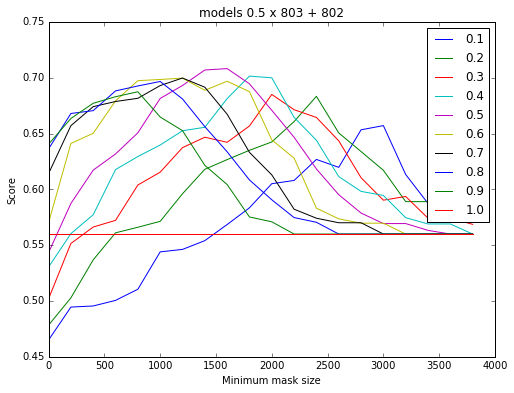

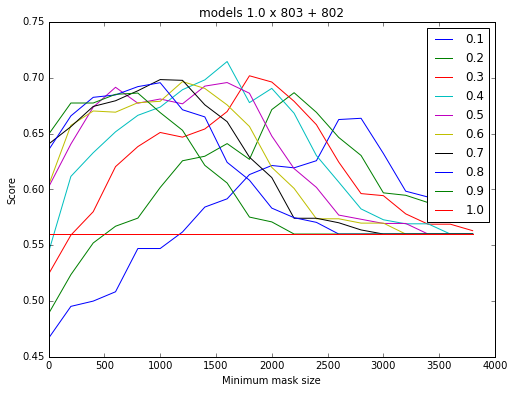

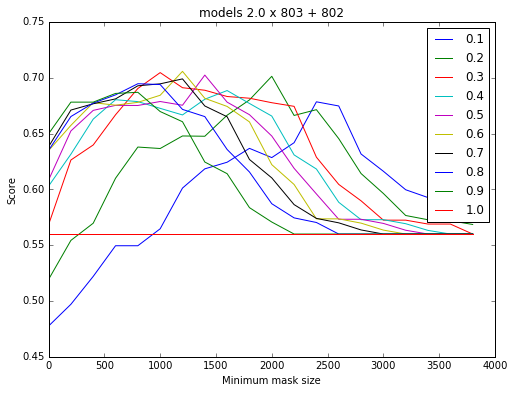

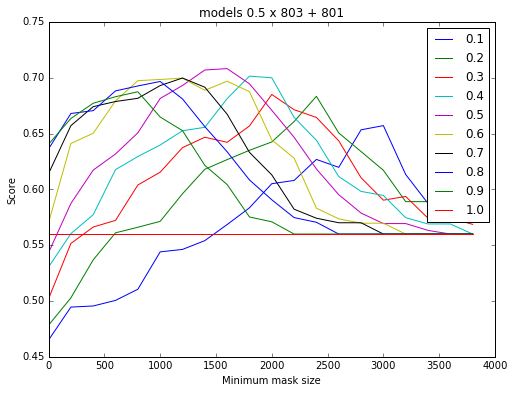

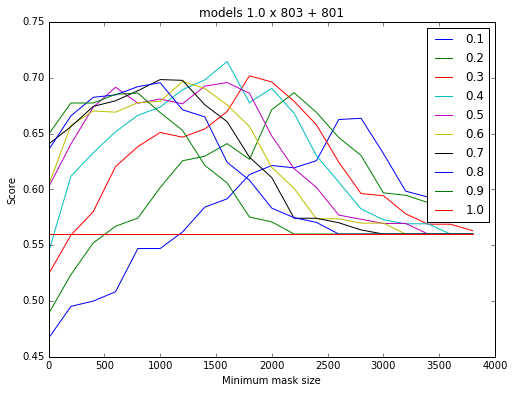

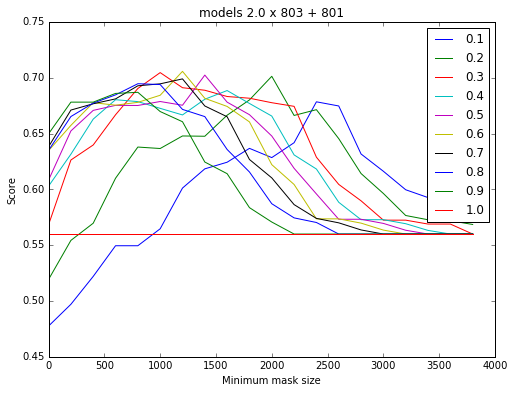

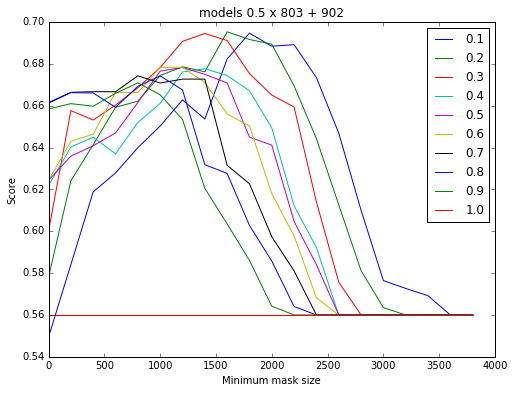

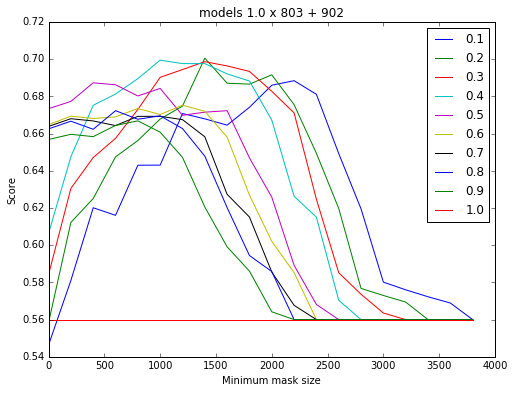

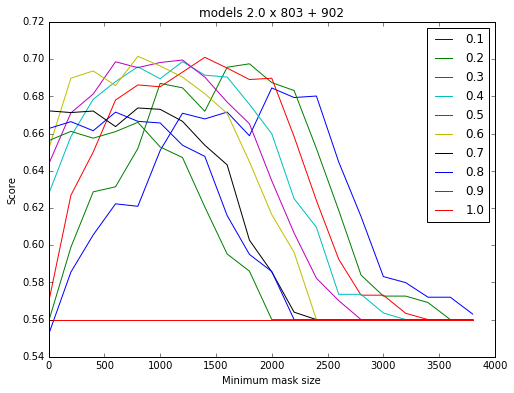

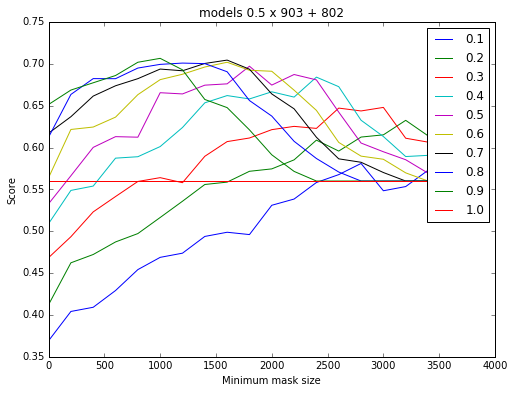

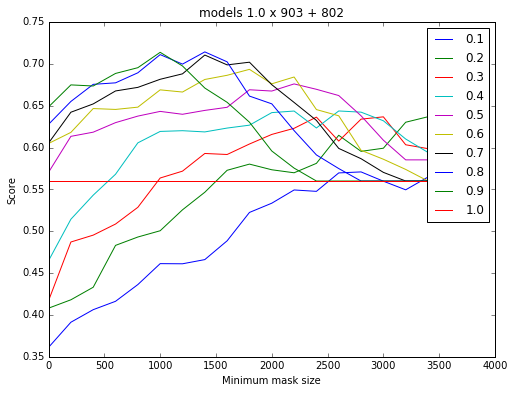

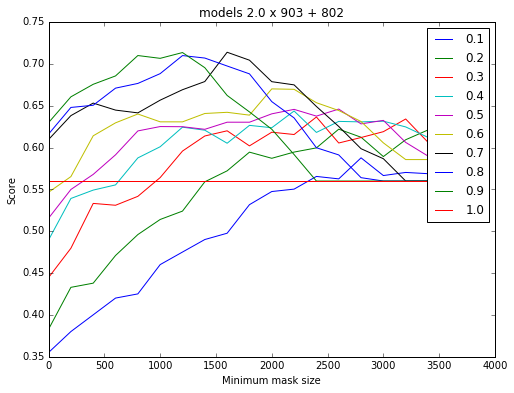

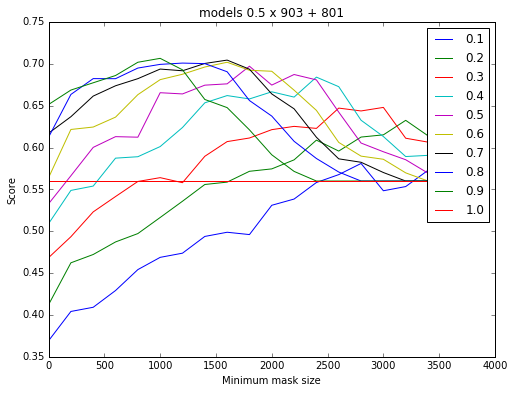

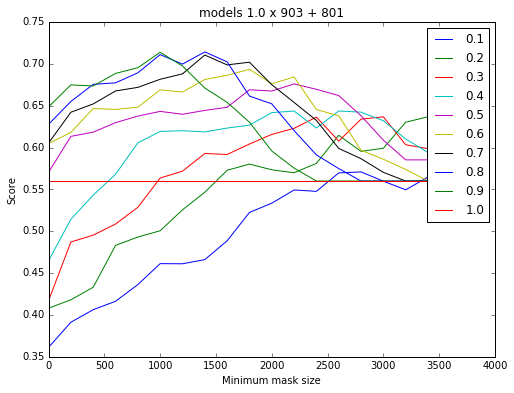

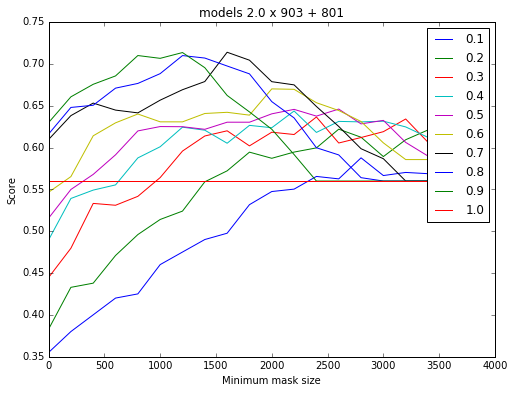

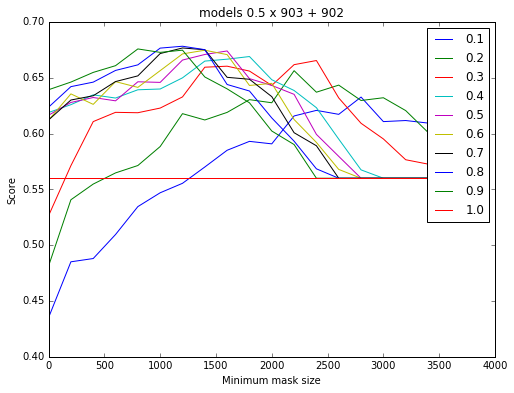

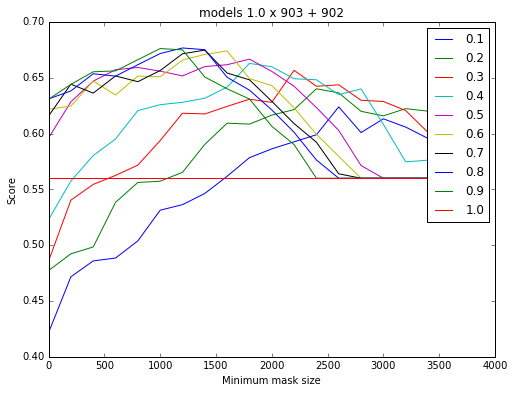

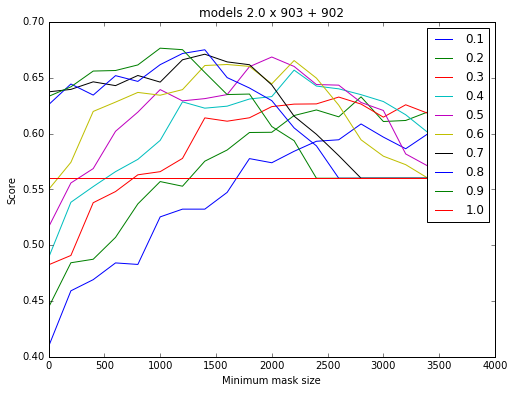

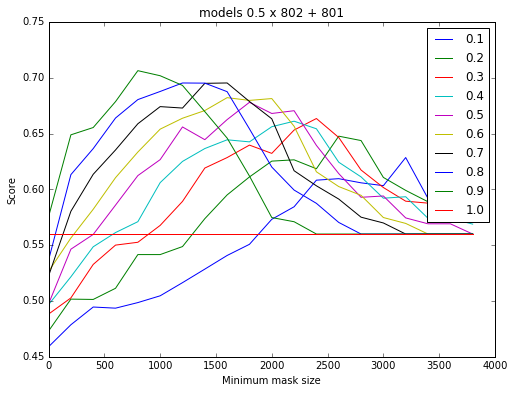

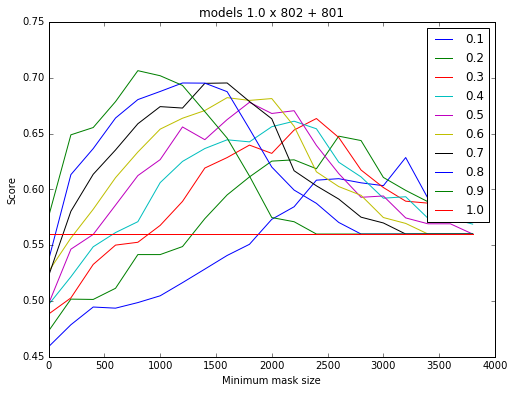

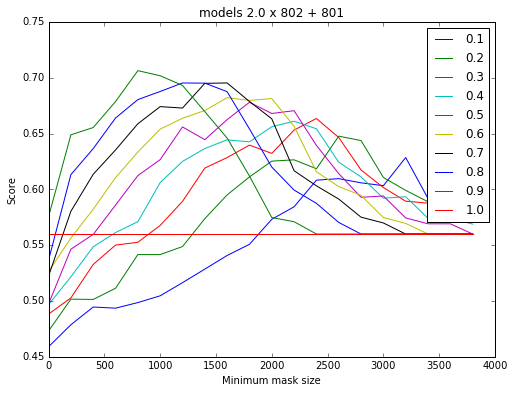

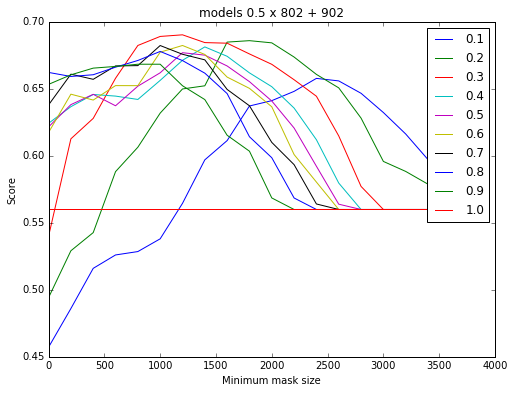

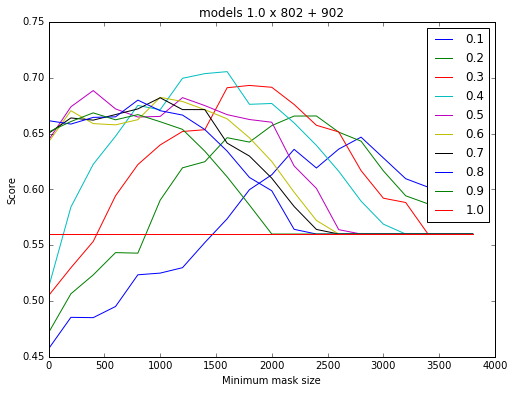

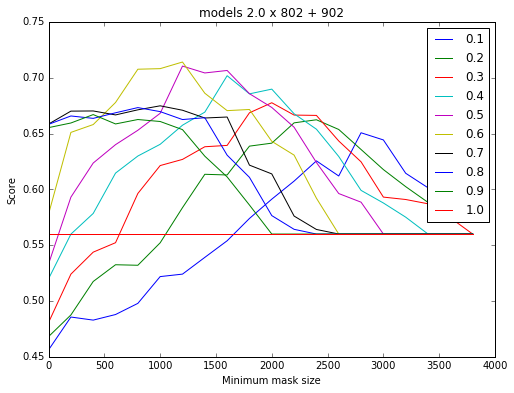

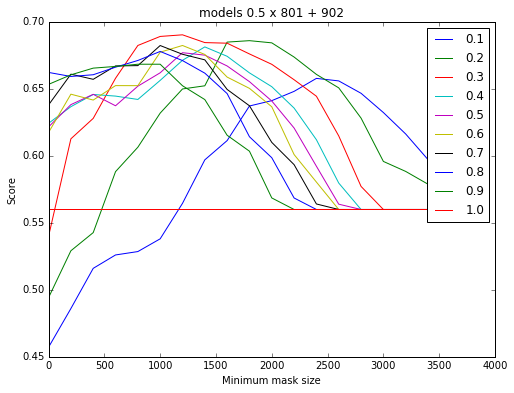

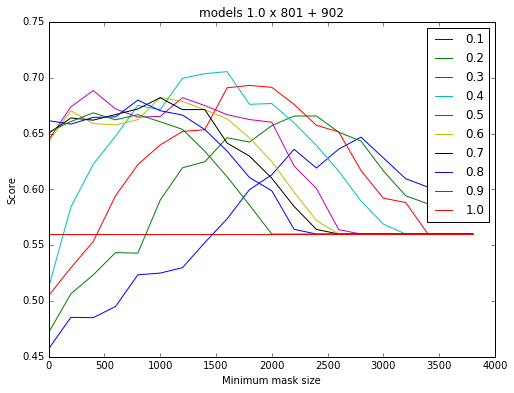

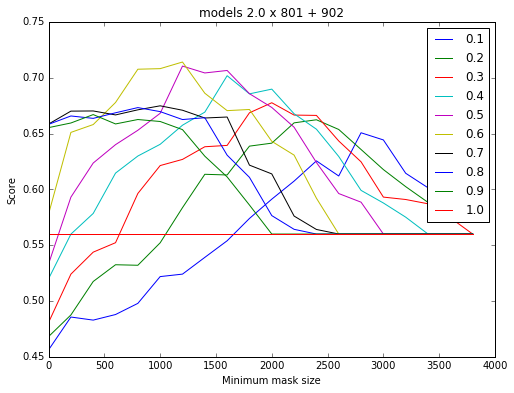

In [59]:
# Pairwise combinations
pairs = []
for im,m1 in enumerate(models):
    othermodels = [m for m in models[im:] if (m!=m1)]
    for m2 in othermodels:
        pairs.append((m1,m2))

# only need to apply weights to one of the pairs
weights = [0.5, 1.0, 2.0]
plt.close('all')
for pair in pairs:
    pltsubset = np.random.choice(np.arange(len(subset)),20)
    model_average(pair, subset)
    for weight in weights:
        P1 = Pr[pair[0]] * weight / (1+weight)
        P2 = Pr[pair[1]] / (1+weight)
        Pavg = P1 + P2
        plot_model_dice(Pavg, GT, title='models {:.1f} x {} + {}'.format(weight, pair[0], pair[1]))
#    for im in pltsubset:
#        fig, ax = plt.subplots(1,2, figsize=(4,1.5))
#        #plot_prob(P1[im,:,:],ax=ax[0])
#        plot_prob(Pavg[im,:,:],GT[im,:,:],ax=ax)
    plt.show()


TypeError: only integer arrays with one element can be converted to an index

## Group event: weighting according to each models individual score

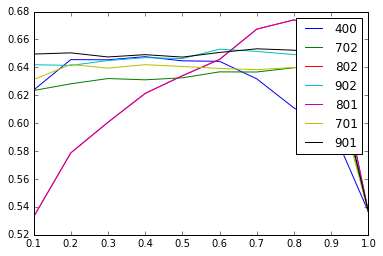

In [125]:
fig, ax = plt.subplots()
for model in models:
    m = [model]
    Pavg, gt_masks = model_average(m, indices)
    cutoffs,_,scores = evaluate_cutoffs(Pavg, gt_masks, minimumsizes=[1000])
    ax.plot(cutoffs, scores.flatten(), label=model)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

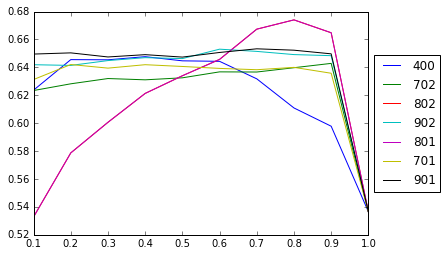

In [126]:
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig

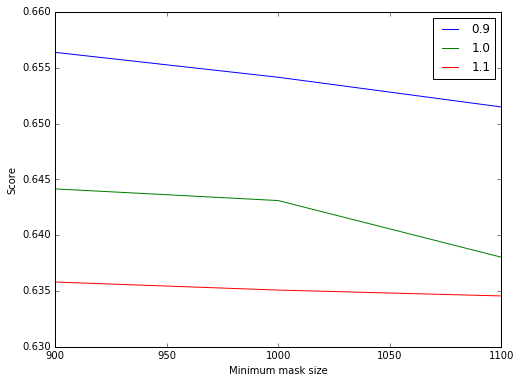

In [140]:
cutoffs = {'400':0.4,'702':0.8,'801':0.8,'802':0.8,'902':0.8,'701':0.5,'901':0.7}
weights = np.array([1/cutoffs[m] for m in models])
Pavg, gt_masks = model_average(models, indices, weights)
plot_model_dice(Pavg, gt_masks, cutoffs=[0.9,1.0,1.1], minimumsizes=[900,1000,1100])

## Probability given models

What is P(Mask|Model1,Model2,Model3,Model4)

Known:
P(Image has mask) -> fixed ~0.51
P(Models|image has mask)

P(pixel has mask) -> known from images, not independent
P(model 
P(Model1) Probability that model says any random pixel has mask ?

In [ ]:
P(m) = P(t)P(t|m)/P(m|t)

In [ ]:
N = 100
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N)
for j,jdx in enumerate(subset):
    for i,m in enumerate(models):
        p = np.load(outputfiles[m][jdx])
        # calculate expected area (sum probability)
        if i == 0:
            size = np.prod(p[0].shape)
            print('{:04d}: {:5.3f}'.format(jdx, np.sum(p[1])/size), end='|')
        print('{:5.3f}'.format(np.sum(p[0])/size), end='|')
    print()

(-0.0005, 0.1)

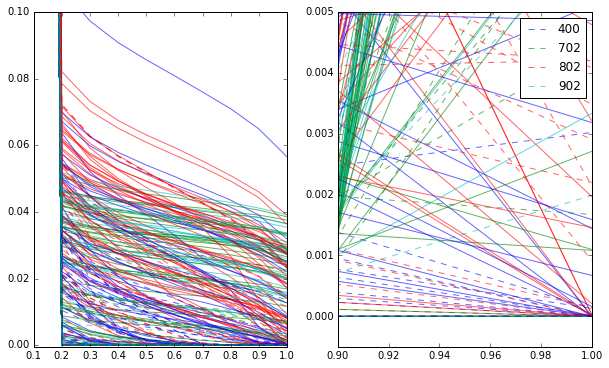

In [8]:
N = 100
fig, ax = plt.subplots(1,2, figsize=(10,6))
col = ('b','g','r','c')
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N)
leg=None
for j,jdx in enumerate(subset):
    for i,m in enumerate(models):
        p = np.load(outputfiles[m][jdx])
        hist = np.histogram(p[0],np.linspace(0,1,11))
        size = np.prod(p[0].shape)
        if np.sum(p[1]) > 0:
            ls = '-' + col[i]
        else:
            ls = '--' + col[i]
        if j==(len(subset)-1):
            leg = m
            
        ax[0].plot(hist[1][1:], np.cumsum(hist[0][::-1])[::-1]/size, ls, alpha=0.6)
        ax[1].plot(hist[1][2:], hist[0][1:]/size, ls, alpha=0.6, label=leg)
        
        #print('{:04d}: {:5.3f}'.format(jdx, np.sum(p[1])/size), end='|')
        #print('{:5.3f}'.format(np.sum(p[0])/size), end='|')
ax[1].legend() 
ax[1].set_xlim(0.9,1.0)
ax[1].set_ylim(-0.0005,0.005)

ax[0].set_ylim(-0.0005,0.1)

In [9]:
# Add new columns:
bins = np.linspace(0,1,11)
for m in models:
    for i in bins[1:]:
        columnname = 'model_{:s}_hist_{:03d}'.format(m,int(i*100))
        training[columnname] = 0
print(training.columns)

Index(['centcol', 'centrow', 'contH', 'contW', 'contour', 'contxmax',
       'contxmin', 'contymax', 'contymin', 'hasmask',
       ...
       'model_902_hist_010', 'model_902_hist_020', 'model_902_hist_030',
       'model_902_hist_040', 'model_902_hist_050', 'model_902_hist_060',
       'model_902_hist_070', 'model_902_hist_080', 'model_902_hist_090',
       'model_902_hist_100'],
      dtype='object', length=148)


In [10]:
for j,jdx in enumerate(indices):
    for i,m in enumerate(models):
        p = np.load(outputfiles[m][j])
        hist = np.histogram(p[0],np.linspace(0,1,11))
        size = np.prod(p[0].shape)
        for h,b in zip(hist[0],hist[1][1:]):
            columnname = 'model_{:s}_hist_{:03d}'.format(m,int(b*100))
            colnum = training.columns.get_loc(columnname)
            training.iloc[jdx, colnum] = h

In [13]:
training.to_msgpack('training.bin')

In [11]:
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
# list of columns:
bins = np.linspace(0,1,11)
columns = []
for m in models:
    for i in bins[1:]:
        columns.append('model_{:s}_hist_{:03d}'.format(m,int(i*100)))


In [12]:
X = training.ix[indices,columns].values/size
X.shape

(958, 40)

In [18]:
y = training.ix[indices,'hasmask'].values
clf = svm.LinearSVC()
clf.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
y_pred = clf.predict(X)
classif_rate = np.mean(y_pred == y) * 100
classif_rate

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred, labels=[True, False])
print(cm)
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

# estimate dice score based on confusion matrix:
(cm_norm[0,0]*.73 + cm_norm[1,1])/2

[[281 163]
 [ 65 449]]
[[ 0.63288288  0.36711712]
 [ 0.12645914  0.87354086]]


0.66777268026781644

In [48]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
Xp = RobustScaler().fit_transform(X)
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(Xp, y).transform(Xp)

/Users/chrisv/anaconda/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


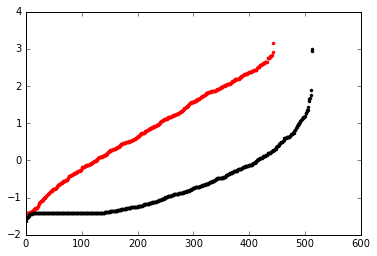

In [49]:
fig, ax = plt.subplots()
ax.plot(sorted(X_r2[y]),'.r')
ax.plot(sorted(X_r2[~y]),'.k')

In [38]:
lda.means_

array([[ 0.04400222, -0.26938399, -0.21953032, -0.09887246,  0.13002445,
         0.25680934,  0.24451908,  0.21974348,  0.17807175,  0.31773235,
        -0.2137178 ,  0.24600614,  0.33427547,  0.31815614,  0.31311945,
         0.30774338,  0.29741776,  0.27080551,  0.2620043 ,  0.22296769,
         0.3244998 , -0.37707684, -0.25484896, -0.2285841 , -0.23950102,
        -0.24135578, -0.26552494, -0.26586609, -0.22747768,  0.12652309,
        -0.19905122,  0.22159659,  0.21516969,  0.20126124,  0.19317922,
         0.19626378,  0.19129401,  0.18777793,  0.18980108,  0.58619868],
       [-0.57216323,  0.15755839,  0.25357346,  0.41710649,  0.66890854,
         0.82193959,  0.81431515,  0.79131131,  0.77947823,  2.33914309,
        -0.78459717,  0.58937596,  0.70689908,  0.68232345,  0.71013938,
         0.68003074,  0.70020475,  0.6701627 ,  0.67466935,  1.15158607,
        -0.18797186,  0.08387786,  0.09582388,  0.10485926,  0.1014974 ,
         0.12466376,  0.13164061,  0.17323358,  0.

## why are we missing masks?

In [ ]:
#predicted area model_???_hist_100 vs mask area
#mask properties
# Classifier? regression?

